In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as scp
from scipy import optimize
from scipy import special
from scipy import stats
from itertools import product
import xarray 
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')

def sample(func,params,rate):
    searching = True
    time = 0
    while searching:
        nextPassage = func(*params)
        nextRate = np.random.exponential(1/rate)
        if nextRate>nextPassage:
            searching = False
            time += nextPassage
        else:
            time += nextRate
    return time

def pade3_2(x,U0,U1,D1,U2,D2,D3):
    return (U2*x**2+x*U1+U0)/(D3*x**3+D2*x**2+x*D1+1)

def pade3_3(x,U0,D0,U1,D1,U2,D2,U3,D3,D4):
    return (U3*x**3+U2*x**2+x*U1+U0)/(D3*x**3+D2*x**2+x*D1+D0)

def pade3_4(x,A,U1,D1,U2,D2,U3,D3,D4):
    return (U3*x**3+U2*x**2+x*U1+A)/(D4*x**4+D3*x**3+D2*x**2+x*D1+A)

def IGLaplace(rs,L,D,V):
    return np.exp(L/(2*D)*(V-np.sqrt(V**2+4*D*rs)))

def forwardExpansion(x,x0,delta,vals):

    first = (-49/20*vals[0] + 6*vals[1] -15/2*vals[2] + 20/3*vals[3] -15/4*vals[4] + 6/5*vals[5] -1/6*vals[6])/delta
    second = (469/90*vals[0] -223/10*vals[1] +879/20*vals[2] -949/18*vals[3] +41*vals[4] -201/10*vals[5] +1019/180*vals[6]-7/10*vals[7])/(delta**2)
    third = (-801/80*vals[0] +349/6*vals[1] -18353/120*vals[2] +2391/10*vals[3] -1457/6*vals[4] +4891/30*vals[5] -561/8*vals[6]+527/30*vals[7]-469/240*vals[8])/(delta**3)
    fourth = (1069/80*vals[0] -1316/15*vals[1] +15289/60*vals[2] -2144/5*vals[3] +10993/24*vals[4] -4772/15*vals[5] +2803/20*vals[6]-536/15*vals[7]+967/240 *vals[8])/(delta**4)
    
    return vals[0] + first*(x-x0) + second*(x-x0)**2/2 + third*(x-x0)**3/6 + fourth*(x-x0)**4/24

We will compare different prediction schemes, using exact analytical values of $\tilde{T}(r)$ and
$\langle T_r \rangle = \frac{1-\tilde{T}(r)}{r\tilde{T}(r)}$.

The chosen distribution is the inverse Gaussian distribution,
$\phi(t) = \frac{L}{\sqrt{4\pi D t^3}}exp\left(-\frac{(L - Vt)^2}{4Dt}\right)$,
with $L =1000000 ,D = 12500000,V = 1$. The mean and CV are $\mu=1000ps, \frac{\sigma}{\mu} = 5$. The best improvement factor is ~ 8.5 for $r^*\approx 0.031ps^{-1}$.

We will compare different schemes for different starting points.

## Pade approximation for $\langle T_r \rangle$:

We will approximate $\langle T_r \rangle$ using $f(r) = \frac{U_3r^3+U_2r^2+U_1r+U_0}{D_3r^3+D_2r^2+D_1r+D_0}$.
We will use 10000 points, from $r=r^*$ to $r_{max} = Cr^*, C=2,10,50$.

For example, here is the case for points between $r^*=0.0001ps^{-1}$ and $r_{max} = 50r^*$:

Text(0, 0.5, '$T_r$ ($ns$)')

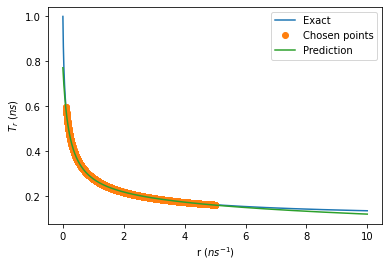

In [2]:
mu = 1000000
CV = 5
D = 0.5*mu*CV**2
m = 2*D/mu
s = mu/m
rs = np.linspace(0,0.00001,10000)
Trs = IGLaplace(rs,mu,D,1)
mus = (1-Trs)/(rs*Trs)
mus[0] = 1e6
plt.plot(rs*1000000,mus/1000000,label="Exact")

rate = 1e-7
selrs = np.linspace(rate,rate*50,10000)
selTrs = IGLaplace(selrs,mu,D,1)
selmus = (1-selTrs)/(selrs*selTrs)
plt.plot(selrs*1000000,selmus/1000000,"o",label="Chosen points")

fit = scp.optimize.curve_fit(pade3_3, selrs, selmus,bounds=(0,np.inf))
pres = pade3_3(rs,*fit[0])
plt.plot(rs*1000000,pres/1000000,label="Prediction")
plt.legend()
plt.xlabel(r"r ($ns^{-1}$)")
plt.ylabel(r"$T_r$ ($ns$)")

## Pade approximation for $\tilde{T}(r)$:

We will approximate $\tilde{T}(r)$ using $f(r) = \frac{U_3r^3+U_2r^2+U_1r+A}{D_4r^4+D_3r^3+D_2r^2+D_1r+A}$.
We will use 10000 points, from $r=r^*$ to $r_{max} = Cr^*, C=2,10,50$ and an additional point, $\tilde{T}(0)=1$.

Then, we can approximate $\langle T_0 \rangle$ by $\langle T_0 \rangle = -\frac{\partial \tilde{T}(0)}{\partial r} \approx \frac{D_1-U_1}{A}$

For example, here is the case for points between $r^*=0.0001ps^{-1}$ and $r_{max} = 50r^*$:

Text(0, 0.5, '$\\tilde{T}(r)$')

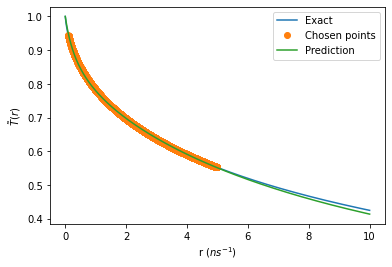

In [3]:
rs = np.linspace(0,0.00001,10000)
Trs = IGLaplace(rs,mu,D,1)
plt.plot(rs*1000000,Trs,label="Exact")
plt.plot(selrs*1000000,selTrs,"o",label="Chosen points")
fit = scp.optimize.curve_fit(pade3_4, selrs, selTrs,bounds=(0,np.inf))
pres = pade3_4(rs,*fit[0])
plt.plot(rs*1000000,pres,label="Prediction")
plt.legend()
plt.xlabel(r"r ($ns^{-1}$)")
plt.ylabel(r"$\tilde{T}(r)$")

## Taylor expansion

We will use forward finite difference approximations for the first four derivatives of $\langle T_r \rangle$
at $r^*$, and evaluate $\langle T_r \rangle$ using a fourth order Taylor expansion.
We will use $\delta = 0.02r^*, 0.1r^*,0.5r^*$ for the distance between grid points for the derivatives.

For example, here is the case for $r^*=0.0001ps^{-1}$ and $\delta = 0.1r^*$:

([<matplotlib.axis.XTick at 0x7f15fb80bee0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

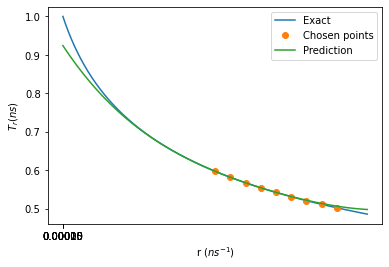

In [4]:
rs = np.linspace(0,0.0000002,10000)
Trs = IGLaplace(rs,mu,D,1)
mus = (1-Trs)/(rs*Trs)
mus[0] = 1e6
plt.plot(rs*1000000,mus/1000000,label="Exact")
selrs = np.linspace(rate,rate+8*rate/10,9)
selTrs = IGLaplace(selrs,mu,D,1)
selmus = (1-selTrs)/(selrs*selTrs)
plt.plot(selrs*1000000,selmus/1000000,"o",label="Chosen points")

pres = forwardExpansion(rs,rate,rate/10,selmus)
plt.plot(rs*1000000,pres/1000000,label="Prediction")
plt.legend()
plt.xlabel(r"r ($ns^{-1}$)")
plt.ylabel(r"$T_r (ns)$")
plt.xticks(np.linspace(0,0.0002,5))

Text(0, 0.5, 'prediction (ns)')

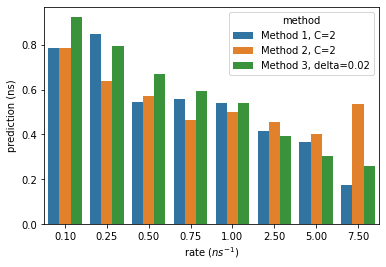

In [19]:
datalist = []
rates = [1e-7,2.5e-7,5e-7,7.5e-7,1e-6,2.5e-6,5e-6,7.5e-6]
for rate in rates:
    ratename = format(rate*1000000,'.2f')
    # method 1+2
    pres2 = []
    for C in [2,10,50]:
        selrs = np.linspace(rate,rate*C,10000)
        selTrs = IGLaplace(selrs,mu,D,1)
        selmus = (1-selTrs)/(selrs*selTrs)
        fit = scp.optimize.curve_fit(pade3_3, selrs, selmus,bounds=(0,np.inf))
        Trs = IGLaplace(rate,mu,D,1)
        mus = (1-Trs)/(rate*Trs)
        prediction = (fit[0][0])/fit[0][1]
        datalist.append(pd.DataFrame(dict(rate = [ratename],method = f"Method 1, C={C}",meanTr = mus/1000000, 
                                          improvement = 1e6/mus, prediction = prediction/1000000, error = abs(1e6-prediction)/1e4)))
        
        fit = scp.optimize.curve_fit(pade3_4, selrs, selTrs,bounds=(0,np.inf))
        pres2.append((fit[0][2]-fit[0][1])/fit[0][0])
    for prediction, C in zip(pres2,[2,10,50]):
        datalist.append(pd.DataFrame(dict(rate = [ratename],method = f"Method 2, C={C}",meanTr = mus/1000000, 
                          improvement = 1e6/mus, prediction = prediction/1000000, error = abs(1e6-prediction)/1e4)))
    
    for delta in [0.02,0.1,0.5]:
        selrs = np.linspace(rate,rate+8*rate*delta,9)
        selTrs = IGLaplace(selrs,mu,D,1)
        selmus = (1-selTrs)/(selrs*selTrs)
        prediction = forwardExpansion(0,rate,rate*delta,selmus)
        datalist.append(pd.DataFrame(dict(rate = [ratename],method = f"Method 3, delta={delta}",meanTr = mus/1000000, 
                          improvement = 1e6/mus, prediction = prediction/1000000, error = abs(1e6-prediction)/1e4)))
    
data = pd.concat(datalist).set_index(["meanTr","improvement"])
pd.set_option('display.max_rows', len(data))
sns.barplot(data=data.query("method in ['Method 1, C=2','Method 2, C=2','Method 3, delta=0.02']"),x="rate",y="prediction",hue="method")
plt.xlabel(r"rate ($ns^{-1}$)")
plt.ylabel("prediction (ns)")

In [20]:
data

rate                method  prediction        error
meanTr   improvement                                                     
0.596934 1.675228     0.10         Method 1, C=2    0.786274    21.372606
         1.675228     0.10        Method 1, C=10    0.882680    11.731964
         1.675228     0.10        Method 1, C=50    0.771700    22.829978
         1.675228     0.10         Method 2, C=2    0.787184    21.281582
         1.675228     0.10        Method 2, C=10    0.562936    43.706427
         1.675228     0.10        Method 2, C=50    0.616868    38.313152
         1.675228     0.10  Method 3, delta=0.02    0.924596     7.540360
         1.675228     0.10   Method 3, delta=0.1    0.924049     7.595143
         1.675228     0.10   Method 3, delta=0.5    0.893373    10.662666
0.451601 2.214345     0.25         Method 1, C=2    0.849808    15.019157
         2.214345     0.25        Method 1, C=10    0.734502    26.549762
         2.214345     0.25        Method 1, C=50    0.609283    39.071720
         2.214345     0.25         Method 2, C=2    0.636774    36.322578
         2.214345     0.25        Method 2, C=10    0.713335    28.666475
         2.214345     0.25        Method 2, C=50    0.552440    44.755970
         2.214345     0.25  Method 3, delta=0.02    0.794972    20.502798
         2.214345     0.25   Method 3, delta=0.1    0.793792    20.620810
         2.214345     0.25   Method 3, delta=0.5    0.745294    25.470584
0.356336 2.806338     0.50         Method 1, C=2    0.543401    45.659921
         2.806338     0.50        Method 1, C=10    0.611570    38.842987
         2.806338     0.50        Method 1, C=50    0.499110    50.088974
         2.806338     0.50         Method 2, C=2    0.571064    42.893562
         2.806338     0.50        Method 2, C=10    0.595099    40.490086
         2.806338     0.50        Method 2, C=50    0.456790    54.321047
         2.806338     0.50  Method 3, delta=0.02    0.668518    33.148183
         2.806338     0.50   Method 3, delta=0.1    0.667073    33.292690
         2.806338     0.50   Method 3, delta=0.5    0.614968    38.503250
0.308602 3.240421     0.75         Method 1, C=2    0.556283    44.371731
         3.240421     0.75        Method 1, C=10    0.482202    51.779820
         3.240421     0.75        Method 1, C=50    0.434068    56.593175
         3.240421     0.75         Method 2, C=2    0.463749    53.625082
         3.240421     0.75        Method 2, C=10    0.381067    61.893295
         3.240421     0.75        Method 2, C=50    0.407068    59.293178
         3.240421     0.75  Method 3, delta=0.02    0.592675    40.732479
         3.240421     0.75   Method 3, delta=0.1    0.591195    40.880485
         3.240421     0.75   Method 3, delta=0.5    0.540528    45.947227
0.278461 3.591165     1.00         Method 1, C=2    0.539203    46.079668
         3.591165     1.00        Method 1, C=10    0.492944    50.705556
         3.591165     1.00        Method 1, C=50    0.557134    44.286602
         3.591165     1.00         Method 2, C=2    0.498859    50.114098
         3.591165     1.00        Method 2, C=10    0.455922    54.407783
         3.591165     1.00        Method 2, C=50    0.371423    62.857743
         3.591165     1.00  Method 3, delta=0.02    0.540468    45.953248
         3.591165     1.00   Method 3, delta=0.1    0.539008    46.099223
         3.591165     1.00   Method 3, delta=0.5    0.490473    50.952749
0.202124 4.947458     2.50         Method 1, C=2    0.414122    58.587848
         4.947458     2.50        Method 1, C=10    0.409501    59.049881
         4.947458     2.50        Method 1, C=50    0.168095    83.190466
         4.947458     2.50         Method 2, C=2    0.456174    54.382554
         4.947458     2.50        Method 2, C=10    0.354176    64.582402
         4.947458     2.50        Method 2, C=50    0.273738    72.626225
         4.947458     2.50  Method 3, delta=0.02    0.392427    60.757322
         4.947458     2.50

Tomorow:
I will add check of evaluation with a very long range, and the same table as above for gamma and Frechet.
Then, I will check the implementation in LAMMPS, and Anna's code.